***Objective for the Tandahimba Crop Classification dataset: 

*   observe some abnormality 
*   total count of 800 data points, look at dates from October, as single dates, for both years, 
*   ndvi, per particular date per cluster of target, 
*   find date and cluster with best correlation
*   Best feature(feature selection)(1st analysis, cluster(2nd analysis,(look at correlations), spectral bands, 3rd analysis; indices(ndvi, etc)

In [382]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [383]:
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 --use-deprecated=legacy-resolver -qq
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [384]:
from pycaret.regression import *

In [385]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from PIL import Image
import pandas as pd
import json
import sys
sys.path.append('/content/drive/MyDrive/mavuno')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
#from mavuno.raster import rasterize_polygon
#from mavuno.sentinel2 import open_region_climatology, S2Basic ,BAND_KEYS
#from convolve2d_masked import moving_averages_masked
##from cashew_mask import predict_cashew_mask
#from tree_biomass_map import cashew_tree_biomass_map
from pandas_profiling import ProfileReport
from datetime import datetime
import warnings
warnings.filterwarnings('ignore') #don't display warnings

In [386]:
trees_df = pd.read_csv('/content/drive/MyDrive/Datasets_Mavuno/Undergrowth/Undergrowths-S2/Crop Classification/Mtwara_district_Classfication_model_data_with_circle_radius(2022-2023).New.csv')
trees_df.head()

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B11,B12,SCL,CLD,cluster,target,ndvi,day of year,month,year
0,2022-01-02 07:42:43,0.038550,0.042650,0.072775,0.061950,0.128450,0.254550,0.303075,0.30640,0.345500,...,0.287775,0.175775,4.0,0.0,polygon_1,1,0.663635,2,1,2022
1,2022-02-01 07:42:41,0.142400,0.144650,0.170150,0.154200,0.209650,0.358175,0.411050,0.40045,0.446575,...,0.353175,0.243375,4.0,0.0,polygon_1,1,0.443974,32,2,2022
2,2022-02-21 07:42:41,0.176450,0.171425,0.197750,0.169100,0.236750,0.413050,0.484825,0.45170,0.508525,...,0.346325,0.232100,4.0,0.0,polygon_1,1,0.455219,52,2,2022
3,2022-03-23 07:42:45,0.158550,0.154650,0.176775,0.154500,0.221275,0.392150,0.462425,0.43900,0.502125,...,0.339025,0.217425,4.0,0.0,polygon_1,1,0.479360,82,3,2022
4,2022-03-28 07:42:49,0.156075,0.147850,0.174200,0.150075,0.217500,0.390250,0.452350,0.42810,0.489400,...,0.327725,0.209000,4.0,0.0,polygon_1,1,0.480867,87,3,2022


In [387]:
#df = pd.read_csv('Mtwara_district_Classfication_model_data_with_circle_radius(2022-2023).New.csv')
#df.head(5)

In [388]:

trees_df['polygon_cluster'] = trees_df['cluster'].str.replace(r'\D+', '')

In [389]:
trees_df.head()

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B12,SCL,CLD,cluster,target,ndvi,day of year,month,year,polygon_cluster
0,2022-01-02 07:42:43,0.038550,0.042650,0.072775,0.061950,0.128450,0.254550,0.303075,0.30640,0.345500,...,0.175775,4.0,0.0,polygon_1,1,0.663635,2,1,2022,1
1,2022-02-01 07:42:41,0.142400,0.144650,0.170150,0.154200,0.209650,0.358175,0.411050,0.40045,0.446575,...,0.243375,4.0,0.0,polygon_1,1,0.443974,32,2,2022,1
2,2022-02-21 07:42:41,0.176450,0.171425,0.197750,0.169100,0.236750,0.413050,0.484825,0.45170,0.508525,...,0.232100,4.0,0.0,polygon_1,1,0.455219,52,2,2022,1
3,2022-03-23 07:42:45,0.158550,0.154650,0.176775,0.154500,0.221275,0.392150,0.462425,0.43900,0.502125,...,0.217425,4.0,0.0,polygon_1,1,0.479360,82,3,2022,1
4,2022-03-28 07:42:49,0.156075,0.147850,0.174200,0.150075,0.217500,0.390250,0.452350,0.42810,0.489400,...,0.209000,4.0,0.0,polygon_1,1,0.480867,87,3,2022,1


In [390]:
trees_df = trees_df.drop(['cluster'], axis=1)

In [391]:
#trees_df = df

In [392]:
#trees_df.columns

In [393]:
# relieve noisy columns
#trees_df = trees_df.drop([ 'B1', 'B9', 'SCL', 'CLD'], axis=1)

In [394]:
# dropping any duplicates
trees_df = trees_df.drop_duplicates()

In [395]:
#trees_df['evi'] = 2.5*(trees_df.B8A - trees_df.B4)/(trees_df.B8A + (6*trees_df.B4) - (7.5*trees_df.B4) +1)
#trees_df['ndvi'] = (trees_df.B8A - trees_df.B4) /  (trees_df.B8A + trees_df.B4)

In [396]:
#trees_df.rename({'undergrowth_type_map':'undergrowth_type', 'undergrowth_height_map':'undergrowth_height', 'undergrowth_type_map_ma':'undergrowth_type_ma', 'undergrowth_height_map_ma':'undergrowth_height_ma', 'cashew_mask_ma': 'cashew_ma' }, axis=1, inplace=True)
print(trees_df.columns)

Index(['datetime', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9',
       'B11', 'B12', 'SCL', 'CLD', 'target', 'ndvi', 'day of year', 'month',
       'year', 'polygon_cluster'],
      dtype='object')


In [397]:
# rows and columns with most value counts

In [398]:
#apply indices

In [399]:
trees_df['evi'] = 2.5*(trees_df.B8A - trees_df.B4)/(trees_df.B8A + (6*trees_df.B4) - (7.5*trees_df.B4) +1)
trees_df['ndvi'] = (trees_df.B8A - trees_df.B4) /  (trees_df.B8A + trees_df.B4)
#data_1['sr'] =  data_1.B8 / data_1.B4
#data_1['gci'] =  (data_1.B8 / data_1.B3) - 1
#data_1['gndvi'] =  (data_1.B8 - data_1.B3) / (data_1.B8 + data_1.B3)
#data_1['rndvi'] =  (data_1.B8 - data_1.B4) / np.sqrt((data_1.B8 + data_1.B4))
#data_1['re1'] =  (data_1.B8 - data_1.B5) / (data_1.B8 + data_1.B5)
#data_1['re2'] =  (data_1.B8 - data_1.B6) / (data_1.B8 + data_1.B6)
#data_1['re3'] =  (data_1.B8 - data_1.B7) / (data_1.B8 + data_1.B7)
#data_1['sccci_1'] =  (data_1.re1 / data_1.ndvi)
#data_1['sccci_2'] =  (data_1.re2 / data_1.ndvi)
#data_1['sccci_2'] =  (data_1.re3 / data_1.ndvi)
#data_1['ci_1'] =  (data_1.B8 / data_1.B5) -1
#data_1['ci_2'] =  (data_1.B8 / data_1.B6) -1
#data_1['ci_3'] =  (data_1.B8 / data_1.B7) -1
#data_1['nred_1'] =  (data_1.B7 - data_1.B5) /(data_1.B7 + data_1.B5)
#data_1['nred_2'] =  (data_1.B7 - data_1.B6) /(data_1.B7 + data_1.B6)
#data_1['nred_3'] =  (data_1.B6 - data_1.B5) /(data_1.B6 + data_1.B5)

In [400]:
trees_df

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B12,SCL,CLD,target,ndvi,day of year,month,year,polygon_cluster,evi
0,2022-01-02 07:42:43,0.038550,0.042650,0.072775,0.061950,0.128450,0.254550,0.303075,0.30640,0.345500,...,0.175775,4.00,0.0,1,0.695914,2,1,2022,1,0.565934
1,2022-02-01 07:42:41,0.142400,0.144650,0.170150,0.154200,0.209650,0.358175,0.411050,0.40045,0.446575,...,0.243375,4.00,0.0,1,0.486663,32,2,2022,1,0.601459
2,2022-02-21 07:42:41,0.176450,0.171425,0.197750,0.169100,0.236750,0.413050,0.484825,0.45170,0.508525,...,0.232100,4.00,0.0,1,0.500904,52,2,2022,1,0.676213
3,2022-03-23 07:42:45,0.158550,0.154650,0.176775,0.154500,0.221275,0.392150,0.462425,0.43900,0.502125,...,0.217425,4.00,0.0,1,0.529412,82,3,2022,1,0.684099
4,2022-03-28 07:42:49,0.156075,0.147850,0.174200,0.150075,0.217500,0.390250,0.452350,0.42810,0.489400,...,0.209000,4.00,0.0,1,0.530631,87,3,2022,1,0.670981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21453,2023-01-02 07:42:46,0.146575,0.145700,0.158925,0.170125,0.196325,0.236625,0.246050,0.23980,0.265500,...,0.259650,4.75,0.0,0,0.218938,2,1,2023,9,0.236004
21454,2022-06-16 07:42:58,0.221275,0.199325,0.214500,0.199500,0.258775,0.369825,0.411000,0.40915,0.441650,...,0.253525,4.75,0.0,0,0.377681,167,6,2022,9,0.529915
21455,2022-10-29 07:42:46,0.153500,0.159500,0.169350,0.188750,0.220900,0.255775,0.282700,0.30410,0.322225,...,0.312050,4.75,0.0,0,0.261216,302,10,2022,9,0.321131
21456,2022-11-08 07:42:46,0.145750,0.152750,0.164750,0.183025,0.211450,0.244350,0.270775,0.28935,0.308425,...,0.305600,4.75,0.0,0,0.255163,312,11,2022,9,0.303224


In [401]:

# looking for unique counts

In [402]:
#print(trees_df.polygon_cluster.unique())
#print(pd.unique(trees_df['datetime']))

In [403]:
#trees_df.polygon_cluster.value_counts()

In [404]:
#sorted_values = trees_df.sort_values(by=["datetime", "day of year", "polygon_cluster"], ascending=False)[["datetime", "day of year", "polygon_cluster"]]
#sorted_values

In [405]:
#sorted_values.groupby('polygon_cluster').sum()

In [406]:

#sorted_values.value_counts().head(60)

In [407]:
trees_df.head(2)

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B12,SCL,CLD,target,ndvi,day of year,month,year,polygon_cluster,evi
0,2022-01-02 07:42:43,0.03855,0.04265,0.072775,0.06195,0.12845,0.254550,0.303075,0.30640,0.345500,...,0.175775,4.0,0.0,1,0.695914,2,1,2022,1,0.565934
1,2022-02-01 07:42:41,0.14240,0.14465,0.170150,0.15420,0.20965,0.358175,0.411050,0.40045,0.446575,...,0.243375,4.0,0.0,1,0.486663,32,2,2022,1,0.601459


# Single Date

In [408]:
from datetime import date


In [409]:
trees_df.datetime = pd.to_datetime(trees_df.datetime)

In [410]:
trees_df = trees_df[(trees_df['datetime'] > pd.datetime(2022,10,1)) & (trees_df['datetime'] < pd.datetime(2022,12,31))]

In [411]:
pd.date_range(start='2022-10-1', end='2022-12-31', closed=None)

DatetimeIndex(['2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04',
               '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08',
               '2022-10-09', '2022-10-10', '2022-10-11', '2022-10-12',
               '2022-10-13', '2022-10-14', '2022-10-15', '2022-10-16',
               '2022-10-17', '2022-10-18', '2022-10-19', '2022-10-20',
               '2022-10-21', '2022-10-22', '2022-10-23', '2022-10-24',
               '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28',
               '2022-10-29', '2022-10-30', '2022-10-31', '2022-11-01',
               '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05',
               '2022-11-06', '2022-11-07', '2022-11-08', '2022-11-09',
               '2022-11-10', '2022-11-11', '2022-11-12', '2022-11-13',
               '2022-11-14', '2022-11-15', '2022-11-16', '2022-11-17',
               '2022-11-18', '2022-11-19', '2022-11-20', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
      

In [412]:
trees_df

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B12,SCL,CLD,target,ndvi,day of year,month,year,polygon_cluster,evi
21,2022-10-04 07:42:54,0.151225,0.146900,0.169525,0.179525,0.225600,0.300600,0.324000,0.33695,0.362350,...,0.294875,4.00,0.0,1,0.337393,277,10,2022,1,0.418149
33,2022-12-28 07:42:46,0.144075,0.151525,0.186000,0.180400,0.250475,0.358825,0.402400,0.41085,0.434275,...,0.313025,4.00,0.0,1,0.413023,362,12,2022,1,0.545416
53,2022-10-04 07:42:54,0.144375,0.140525,0.168525,0.168425,0.226400,0.311725,0.342200,0.35505,0.379650,...,0.302825,4.00,0.0,1,0.385394,277,10,2022,1,0.468551
54,2022-10-09 07:42:45,0.169750,0.165850,0.180550,0.174150,0.224375,0.302675,0.332775,0.34835,0.353075,...,0.236875,4.00,0.0,1,0.339371,282,10,2022,1,0.409683
55,2022-10-19 07:42:46,0.150800,0.151300,0.174275,0.175325,0.223475,0.303775,0.335750,0.35200,0.365275,...,0.302275,4.00,0.0,1,0.351369,292,10,2022,1,0.430809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,2022-12-18 07:42:46,0.151325,0.155600,0.170200,0.184075,0.218125,0.256650,0.282900,0.26910,0.299925,...,0.272425,4.75,0.0,0,0.239360,352,12,2022,8,0.282889
21452,2022-12-18 07:42:46,0.153475,0.159425,0.174425,0.195525,0.232450,0.266350,0.294100,0.29960,0.328025,...,0.320000,4.75,0.0,0,0.253080,352,12,2022,8,0.320130
21455,2022-10-29 07:42:46,0.153500,0.159500,0.169350,0.188750,0.220900,0.255775,0.282700,0.30410,0.322225,...,0.312050,4.75,0.0,0,0.261216,302,10,2022,9,0.321131
21456,2022-11-08 07:42:46,0.145750,0.152750,0.164750,0.183025,0.211450,0.244350,0.270775,0.28935,0.308425,...,0.305600,4.75,0.0,0,0.255163,312,11,2022,9,0.303224


In [413]:
# cleaning data of charactors

In [414]:
trees_df.head(5)

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B12,SCL,CLD,target,ndvi,day of year,month,year,polygon_cluster,evi
21,2022-10-04 07:42:54,0.151225,0.146900,0.169525,0.179525,0.225600,0.300600,0.324000,0.33695,0.362350,...,0.294875,4.0,0.0,1,0.337393,277,10,2022,1,0.418149
33,2022-12-28 07:42:46,0.144075,0.151525,0.186000,0.180400,0.250475,0.358825,0.402400,0.41085,0.434275,...,0.313025,4.0,0.0,1,0.413023,362,12,2022,1,0.545416
53,2022-10-04 07:42:54,0.144375,0.140525,0.168525,0.168425,0.226400,0.311725,0.342200,0.35505,0.379650,...,0.302825,4.0,0.0,1,0.385394,277,10,2022,1,0.468551
54,2022-10-09 07:42:45,0.169750,0.165850,0.180550,0.174150,0.224375,0.302675,0.332775,0.34835,0.353075,...,0.236875,4.0,0.0,1,0.339371,282,10,2022,1,0.409683
55,2022-10-19 07:42:46,0.150800,0.151300,0.174275,0.175325,0.223475,0.303775,0.335750,0.35200,0.365275,...,0.302275,4.0,0.0,1,0.351369,292,10,2022,1,0.430809


In [415]:
trees_df.shape

(5543, 22)

In [416]:
trees_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5543 entries, 21 to 21457
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         5543 non-null   datetime64[ns]
 1   B1               5543 non-null   float64       
 2   B2               5543 non-null   float64       
 3   B3               5543 non-null   float64       
 4   B4               5543 non-null   float64       
 5   B5               5543 non-null   float64       
 6   B6               5543 non-null   float64       
 7   B7               5543 non-null   float64       
 8   B8               5543 non-null   float64       
 9   B8A              5543 non-null   float64       
 10  B9               5543 non-null   float64       
 11  B11              5543 non-null   float64       
 12  B12              5543 non-null   float64       
 13  SCL              5543 non-null   float64       
 14  CLD              5543 non-null   float

In [417]:
trees_df.describe().T

,count,mean,std,min,25%,50%,75%,max
B1,5543.0,0.159827,0.017822,0.120750,0.147212,0.156200,0.168850,0.308225
B2,5543.0,0.157210,0.017556,0.113050,0.144100,0.154350,0.167187,0.265900
B3,5543.0,0.184306,0.018806,0.116775,0.171150,0.181950,0.195475,0.304200
B4,5543.0,0.180995,0.026849,0.109475,0.161087,0.176875,0.198050,0.348100
B5,5543.0,0.250397,0.026743,0.125300,0.232137,0.248600,0.267462,0.374650
B6,5543.0,0.347550,0.042786,0.166200,0.318825,0.348775,0.376525,0.483825
B7,5543.0,0.386068,0.049517,0.184750,0.352300,0.387375,0.419525,0.548675
B8,5543.0,0.397018,0.053882,0.175575,0.360575,0.399150,0.433425,0.563600
B8A,5543.0,0.422529,0.052007,0.187875,0.387225,0.423175,0.457050,0.592300
B9,5543.0,0.414129,0.043872,0.218225,0.385312,0.413875,0.443237,0.550275


In [418]:
# The Correlations
pearsoncorr =trees_df.corr(method='pearson')
pearsoncorr

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,SCL,CLD,target,ndvi,day of year,month,year,evi
B1,1.000000,0.808822,0.729354,0.594965,0.643759,0.388818,0.368038,0.328889,0.394862,0.458973,0.525863,0.446429,0.194553,NaN,-0.042622,-0.226435,-0.247695,-0.216627,NaN,0.135317
B2,0.808822,1.000000,0.920078,0.872170,0.787580,0.402586,0.382841,0.346795,0.408089,0.434461,0.707759,0.637037,0.285878,NaN,-0.320050,-0.455138,-0.207747,-0.207288,NaN,0.022134
B3,0.729354,0.920078,1.000000,0.851929,0.922633,0.640405,0.604490,0.578945,0.617288,0.587922,0.732719,0.646364,0.202154,NaN,-0.200466,-0.270689,-0.165366,-0.163067,NaN,0.247446
B4,0.594965,0.872170,0.851929,1.000000,0.829222,0.286158,0.246610,0.224313,0.272651,0.278531,0.849191,0.838149,0.425346,NaN,-0.418149,-0.665074,-0.175701,-0.169732,NaN,-0.172899
B5,0.643759,0.787580,0.922633,0.829222,1.000000,0.687517,0.641807,0.612466,0.659296,0.624337,0.826694,0.745658,0.202262,NaN,-0.103577,-0.216449,-0.155325,-0.145213,NaN,0.304217
B6,0.388818,0.402586,0.640405,0.286158,0.687517,1.000000,0.990310,0.960326,0.981293,0.881322,0.381565,0.210571,-0.217598,NaN,0.180761,0.506288,-0.125614,-0.120575,NaN,0.874211
B7,0.368038,0.382841,0.604490,0.246610,0.641807,0.990310,1.000000,0.965962,0.990217,0.887634,0.352678,0.171511,-0.245831,NaN,0.173973,0.546682,-0.115999,-0.119841,NaN,0.900317
B8,0.328889,0.346795,0.578945,0.224313,0.612466,0.960326,0.965962,1.000000,0.965009,0.832240,0.350364,0.157749,-0.260780,NaN,0.142460,0.546916,-0.173912,-0.176171,NaN,0.884587
B8A,0.394862,0.408089,0.617288,0.272651,0.659296,0.981293,0.990217,0.965009,1.000000,0.903146,0.393357,0.184288,-0.248188,NaN,0.143630,0.530383,-0.145720,-0.142912,NaN,0.898686
B9,0.458973,0.434461,0.587922,0.278531,0.624337,0.881322,0.887634,0.832240,0.903146,1.000000,0.390627,0.185875,-0.195970,NaN,0.190247,0.450459,-0.204253,-0.193395,NaN,0.798172


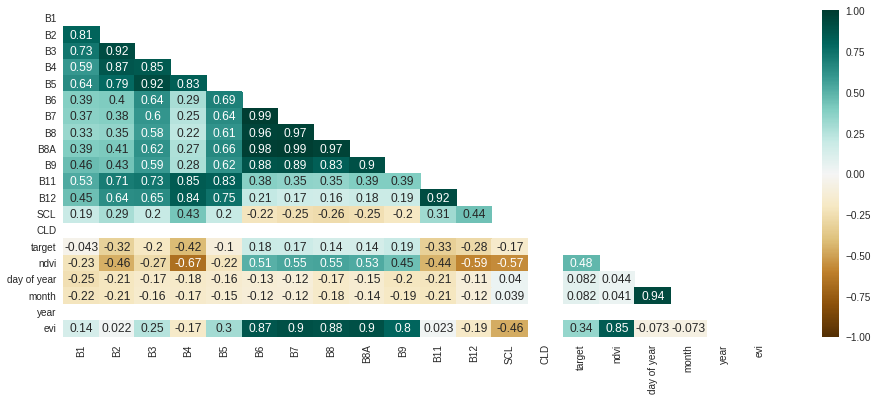

In [419]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(trees_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(trees_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [420]:
# Correlations


In [421]:
trees_df.head(2)

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B12,SCL,CLD,target,ndvi,day of year,month,year,polygon_cluster,evi
21,2022-10-04 07:42:54,0.151225,0.146900,0.169525,0.179525,0.225600,0.300600,0.3240,0.33695,0.362350,...,0.294875,4.0,0.0,1,0.337393,277,10,2022,1,0.418149
33,2022-12-28 07:42:46,0.144075,0.151525,0.186000,0.180400,0.250475,0.358825,0.4024,0.41085,0.434275,...,0.313025,4.0,0.0,1,0.413023,362,12,2022,1,0.545416


# Maximum value counts by column

In [422]:
# find the maximum of each column
maxValues = trees_df.max()
 
print(maxValues)

datetime           2022-12-28 07:42:46
B1                            0.308225
B2                              0.2659
B3                              0.3042
B4                              0.3481
B5                             0.37465
B6                            0.483825
B7                            0.548675
B8                              0.5636
B8A                             0.5923
B9                            0.550275
B11                           0.579725
B12                             0.4629
SCL                               4.75
CLD                                0.0
target                               1
ndvi                          0.617201
day of year                        362
month                               12
year                              2022
polygon_cluster                      9
evi                           0.817836
dtype: object


In [423]:

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(trees_df, .9)

evi          B7       0.900317
B9           B8A      0.903146
B12          B11      0.919819
B2           B3       0.920078
B5           B3       0.922633
day of year  month    0.935623
B8           B6       0.960326
             B8A      0.965009
B7           B8       0.965962
B8A          B6       0.981293
             B7       0.990217
B6           B7       0.990310
B1           B1            NaN
dtype: float64

In [424]:
# looking for date with most value counts

In [425]:



trees_df['day of year'].value_counts()

317    589
332    556
312    475
277    473
362    422
292    407
337    369
352    334
282    313
322    284
327    280
302    249
287    189
342    183
307    174
347    126
297    120
Name: day of year, dtype: int64

In [426]:
#trees_df['datetime'].value_counts()

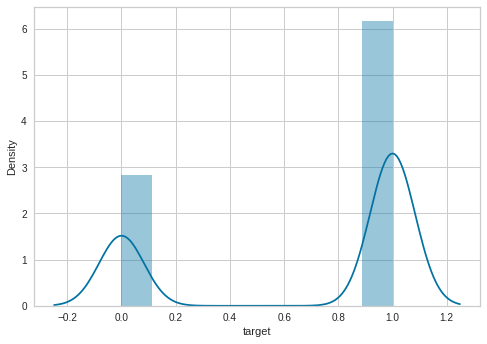

In [427]:
sns.distplot(trees_df['target'])
plt.show()

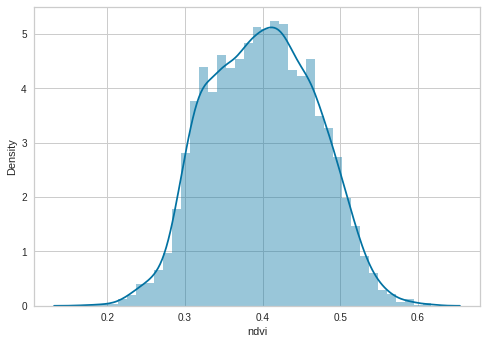

In [428]:
sns.distplot(trees_df['ndvi'])
plt.show()

In [429]:
from pycaret.classification import*

In [430]:
from scipy.stats import skew

[Text(0.5, 1.0, 'NDVI sequence by cluster for Mtwara Region month of Oct - Dec 2022: Crop Classification')]

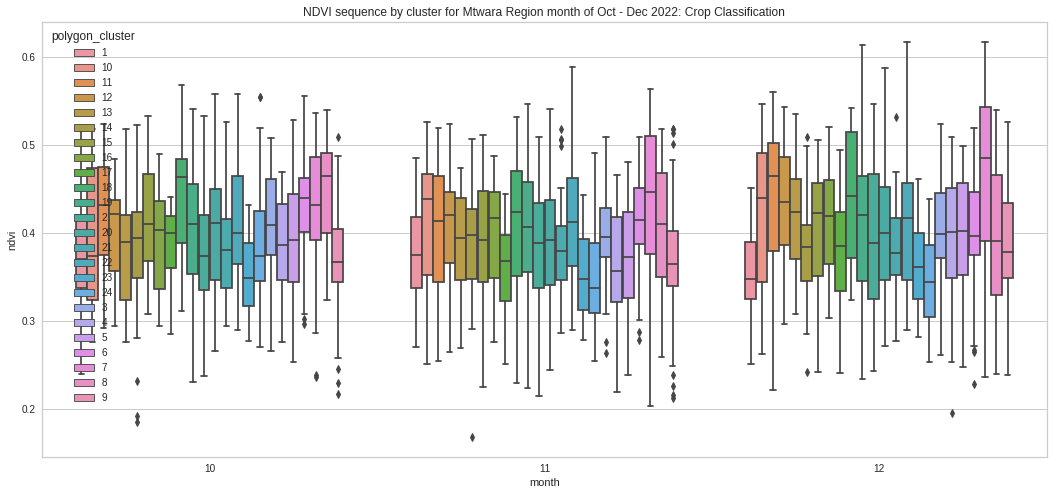

In [431]:
# by year
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="month", y="ndvi", hue="polygon_cluster").set(title='NDVI sequence by cluster for Mtwara Region month of Oct - Dec 2022: Crop Classification')

[Text(0.5, 1.0, 'NDVI sequence by cluster for Mtwara Region for Oct - Dec  2022: Crop Classification')]

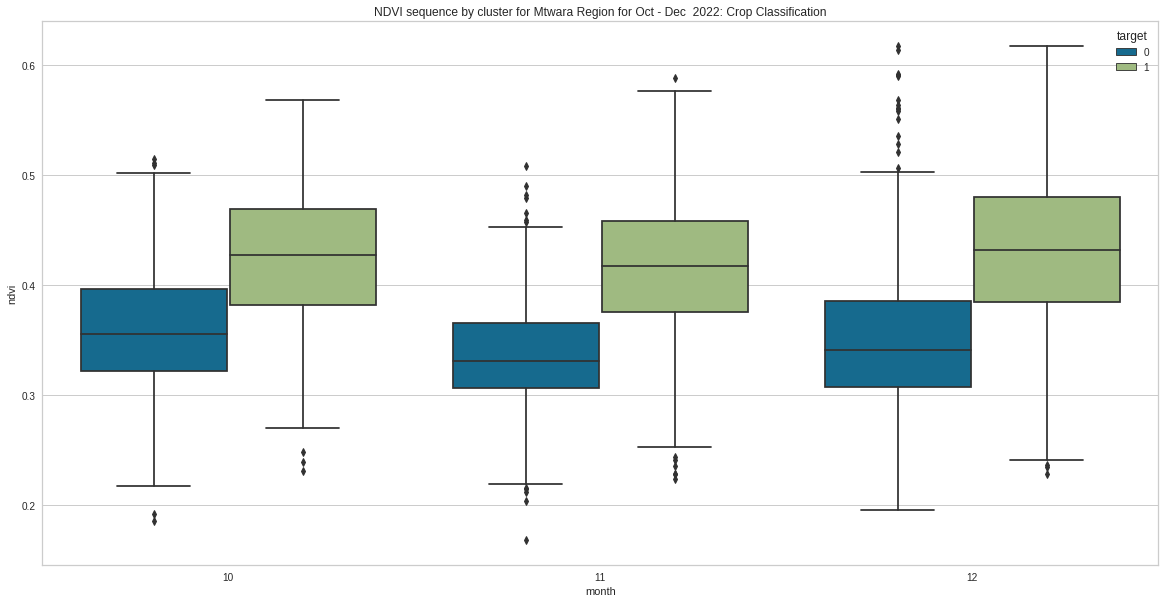

In [432]:
# by year,
plt.figure(figsize=(20, 10))

sns.boxplot(data=trees_df, x="month", y="ndvi", hue="target").set(title='NDVI sequence by cluster for Mtwara Region for Oct - Dec  2022: Crop Classification')

[Text(0.5, 1.0, 'NDVI sequence against Cashew and non Cashew for Mtwara Region for each day with most pixels in Oct - Dec 2022: Crop Classification')]

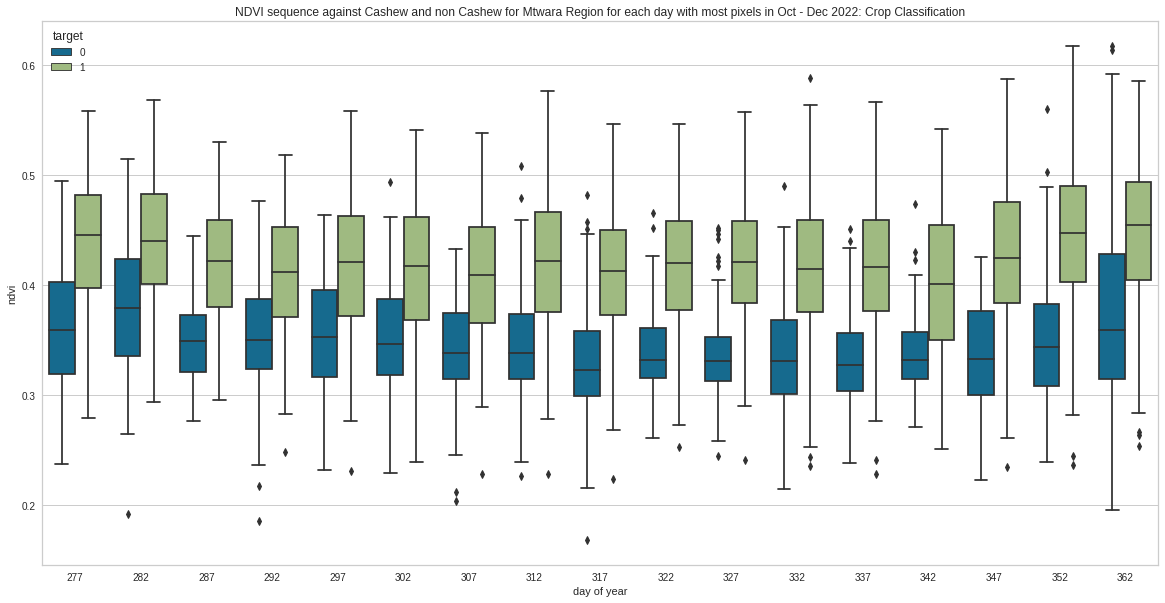

In [433]:
# by year,
plt.figure(figsize=(20, 10))

sns.boxplot(data=trees_df, x="day of year", y="ndvi", hue="target").set(title='NDVI sequence against Cashew and non Cashew for Mtwara Region for each day with most pixels in Oct - Dec 2022: Crop Classification')

[Text(0.5, 1.0, 'NDVI sequence by cluster for Mtwara Region for Oct - Dec 2022: Crop Classification')]

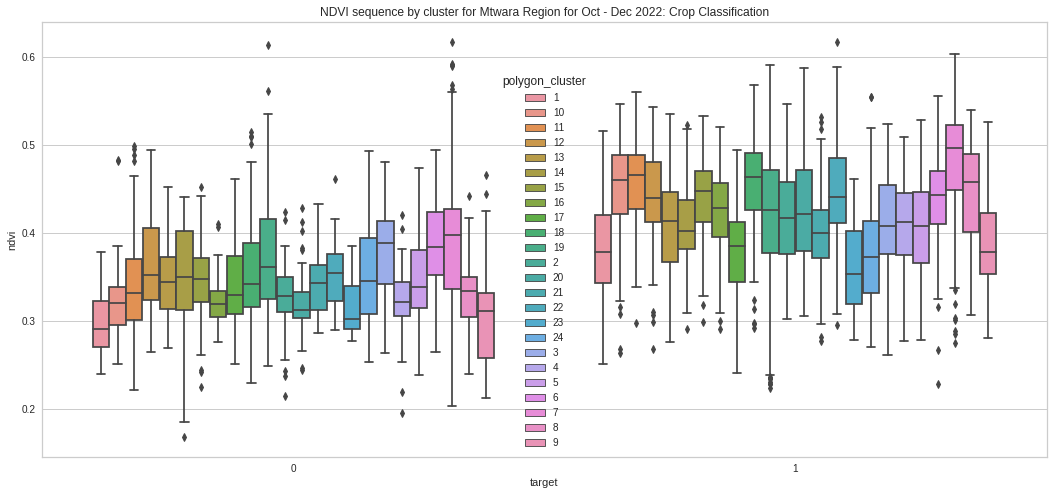

In [434]:
# by year
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="ndvi", hue="polygon_cluster").set(title='NDVI sequence by cluster for Mtwara Region for Oct - Dec 2022: Crop Classification')


# against spectral Bands

[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B3: Crop Classification')]

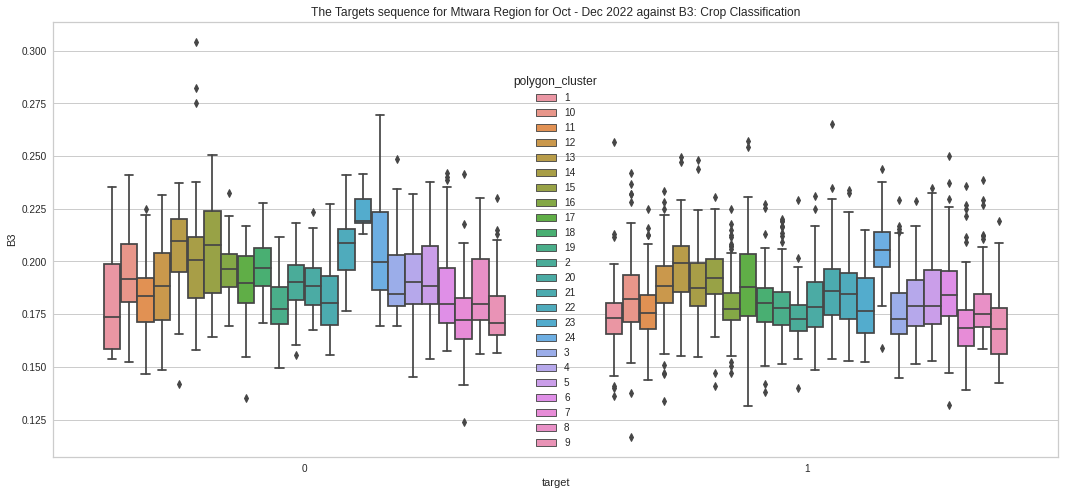

In [435]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B3", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B3: Crop Classification')

# takes way too long to execute

[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B4: Crop Classification')]

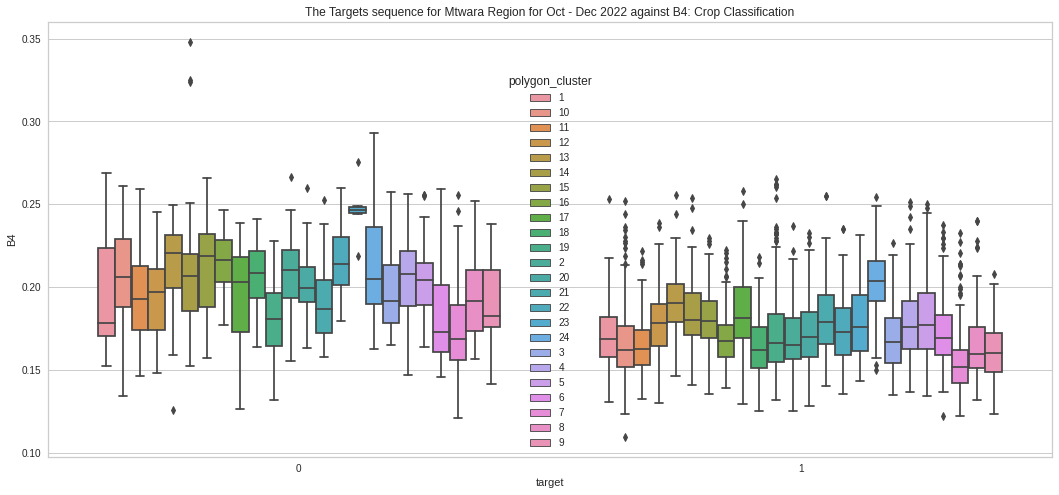

In [436]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B4", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B4: Crop Classification')


[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B5: Crop Classification')]

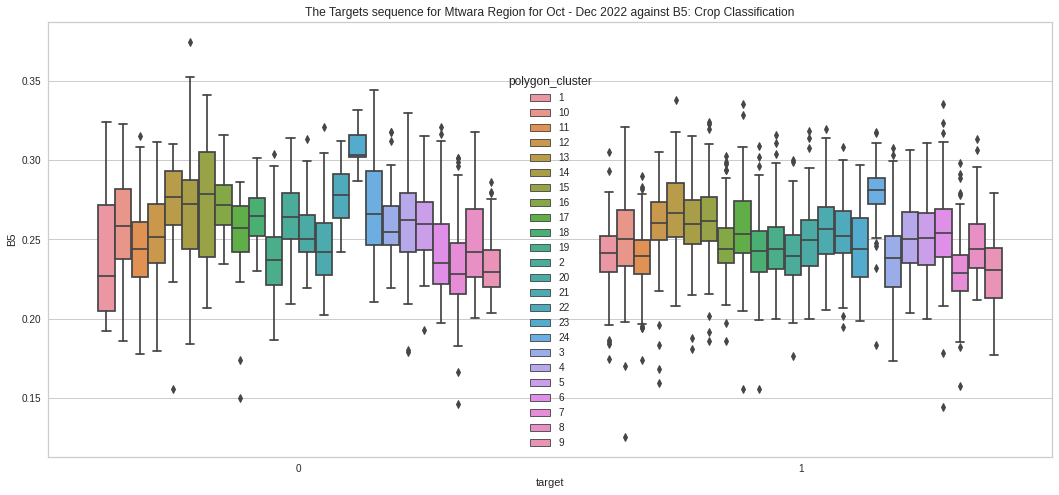

In [437]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B5", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B5: Crop Classification')


[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B6: Crop Classification')]

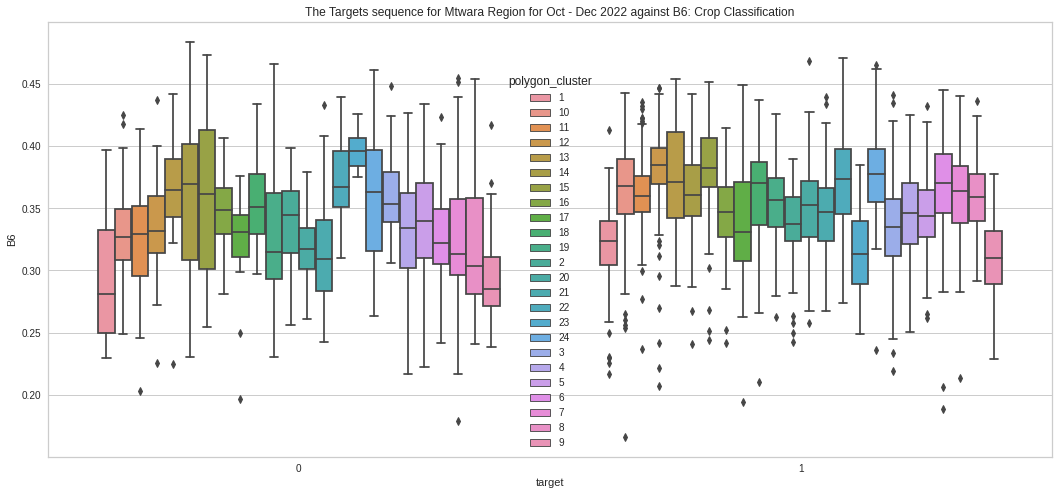

In [438]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B6", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B6: Crop Classification')


[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B7: Crop Classification')]

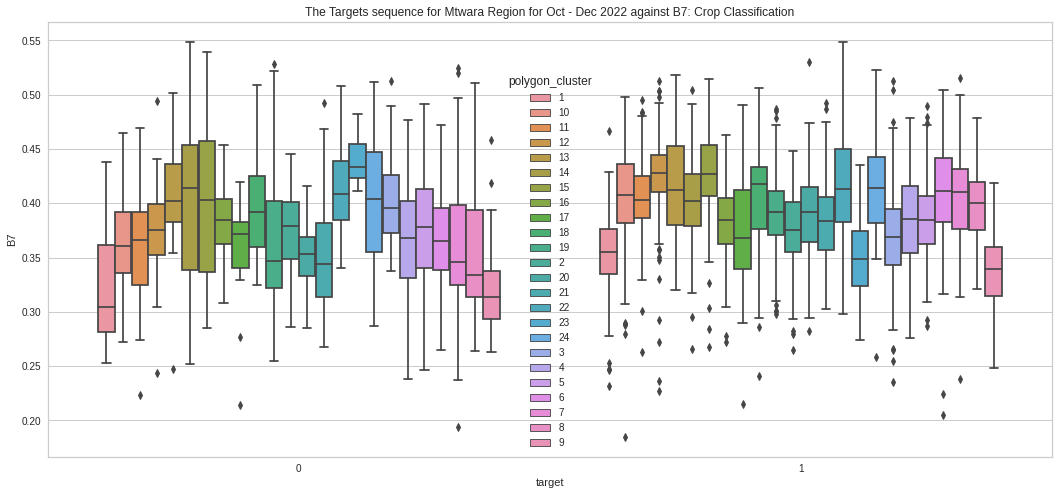

In [439]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B7", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B7: Crop Classification')


[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B8: Crop Classification')]

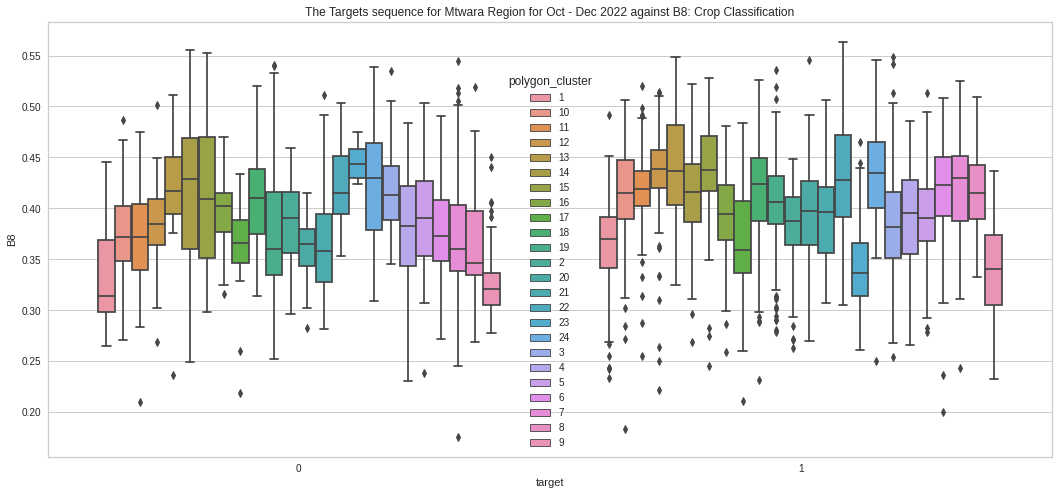

In [440]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B8", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B8: Crop Classification')


[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B8A: Crop Classification')]

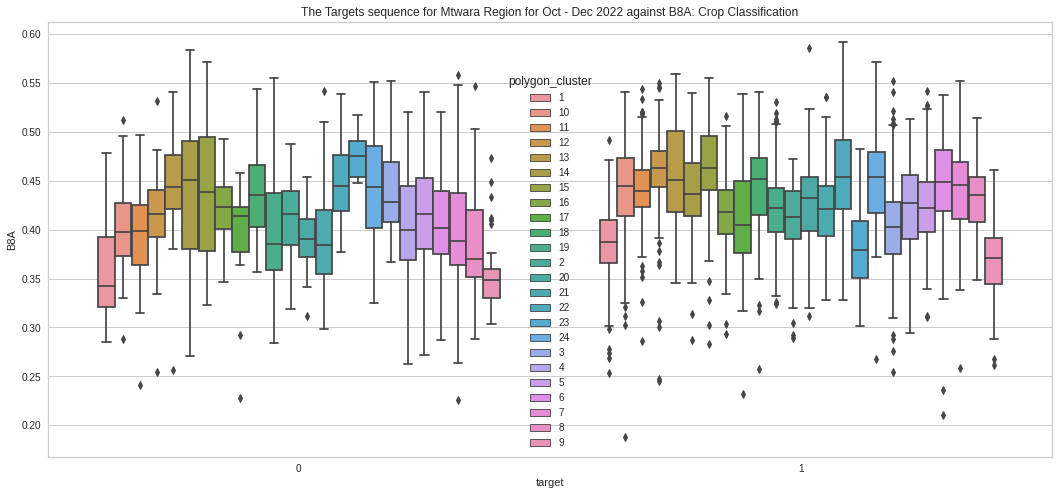

In [441]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B8A", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B8A: Crop Classification')


[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region between Oct - Dec 2022 against B11: Crop Classification')]

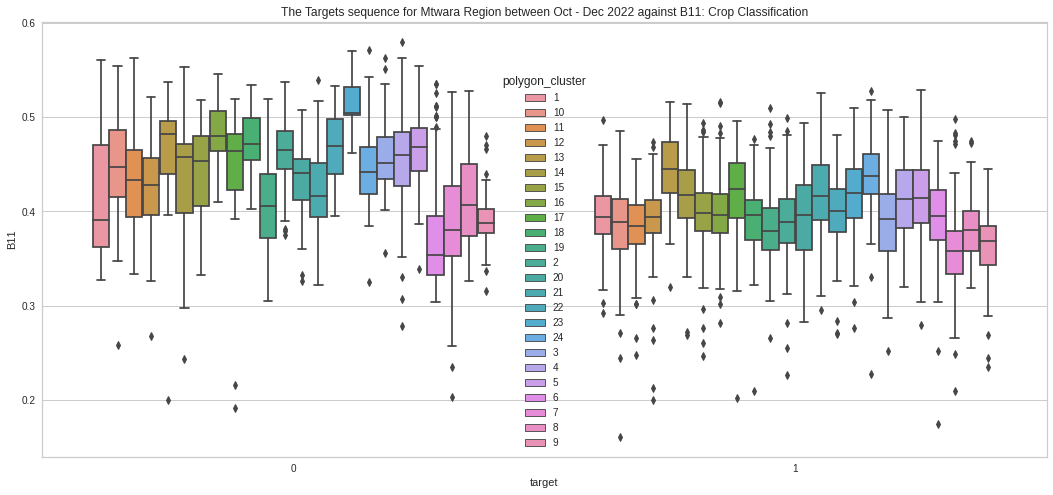

In [442]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B11", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region between Oct - Dec 2022 against B11: Crop Classification')


[Text(0.5, 1.0, 'The Targets sequence for Mtwara Region for Oct - Dec 2022 against B12: Crop Classification')]

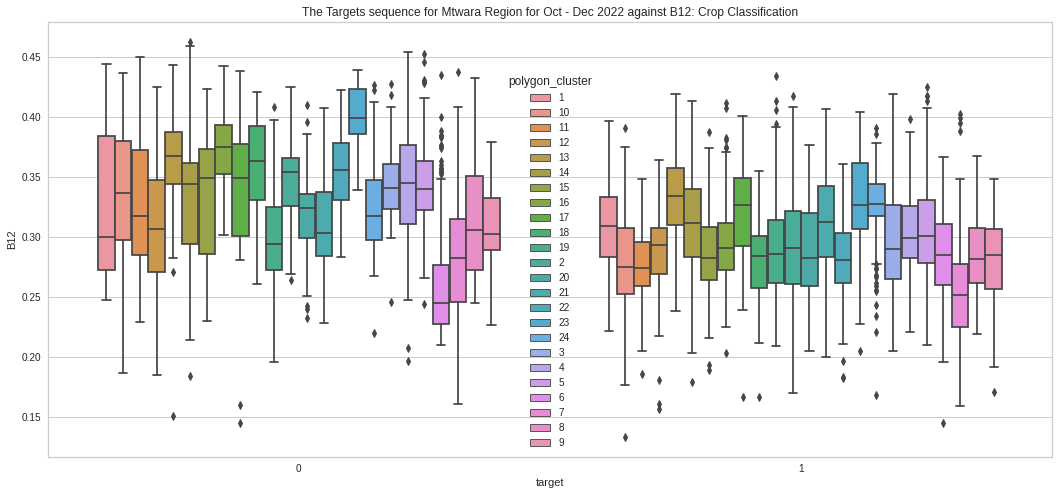

In [443]:
# by month
plt.figure(figsize=(18, 8))

sns.boxplot(data=trees_df, x="target", y="B12", hue="polygon_cluster").set(title='The Targets sequence for Mtwara Region for Oct - Dec 2022 against B12: Crop Classification')


In [454]:
#Non-cashew important polygons; 14, 15, 18, 24, : cashew; 10, 13, 15, 22, 24, 7,5
# Spectral bands B4, B11 - B12 are aligned more with non cashew, while B6 - B8A aligned more to cashew

# NDVI vs Spectral Bands by polgon cluster

[Text(0.5, 1.0, 'Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B4 for each polygon: Crop Classification')]

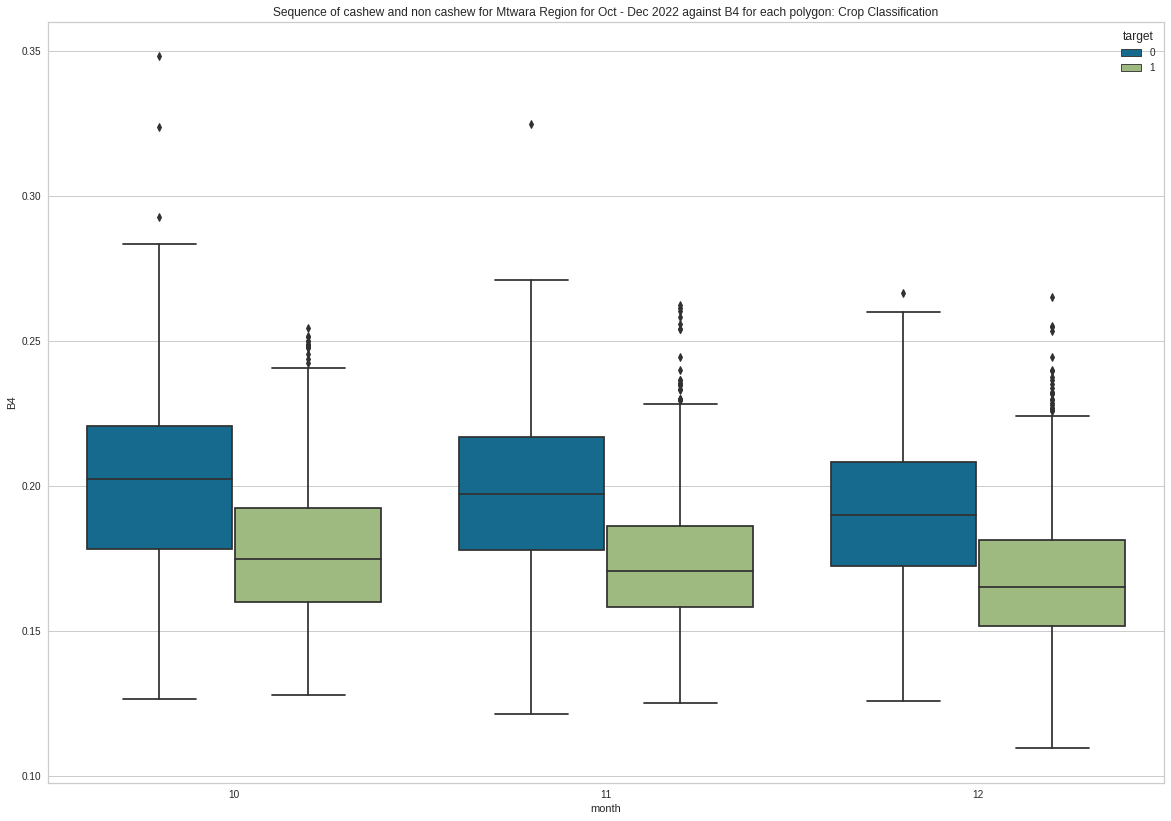

In [455]:
# NDVi vs B6 by polygon cluster
plt.figure(figsize=(20, 14))


sns.boxplot(data=trees_df, x="month", y="B4", hue="target").set(title='Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B4 for each polygon: Crop Classification')


[Text(0.5, 1.0, 'Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B6 for each polygon: Crop Classification')]

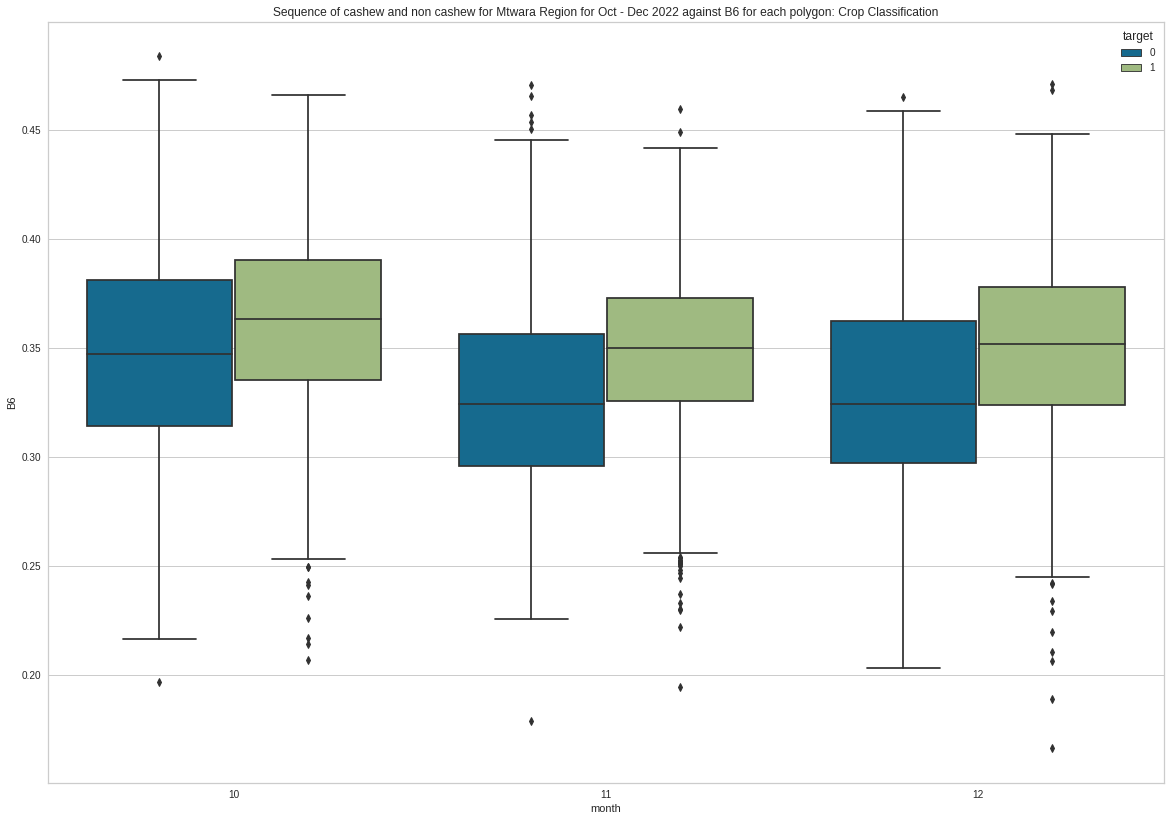

In [456]:

# NDVi vs B6 by polygon cluster
plt.figure(figsize=(20, 14))


sns.boxplot(data=trees_df, x="month", y="B6", hue="target").set(title='Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B6 for each polygon: Crop Classification')


[Text(0.5, 1.0, 'Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B7 for each polygon: Crop Classification')]

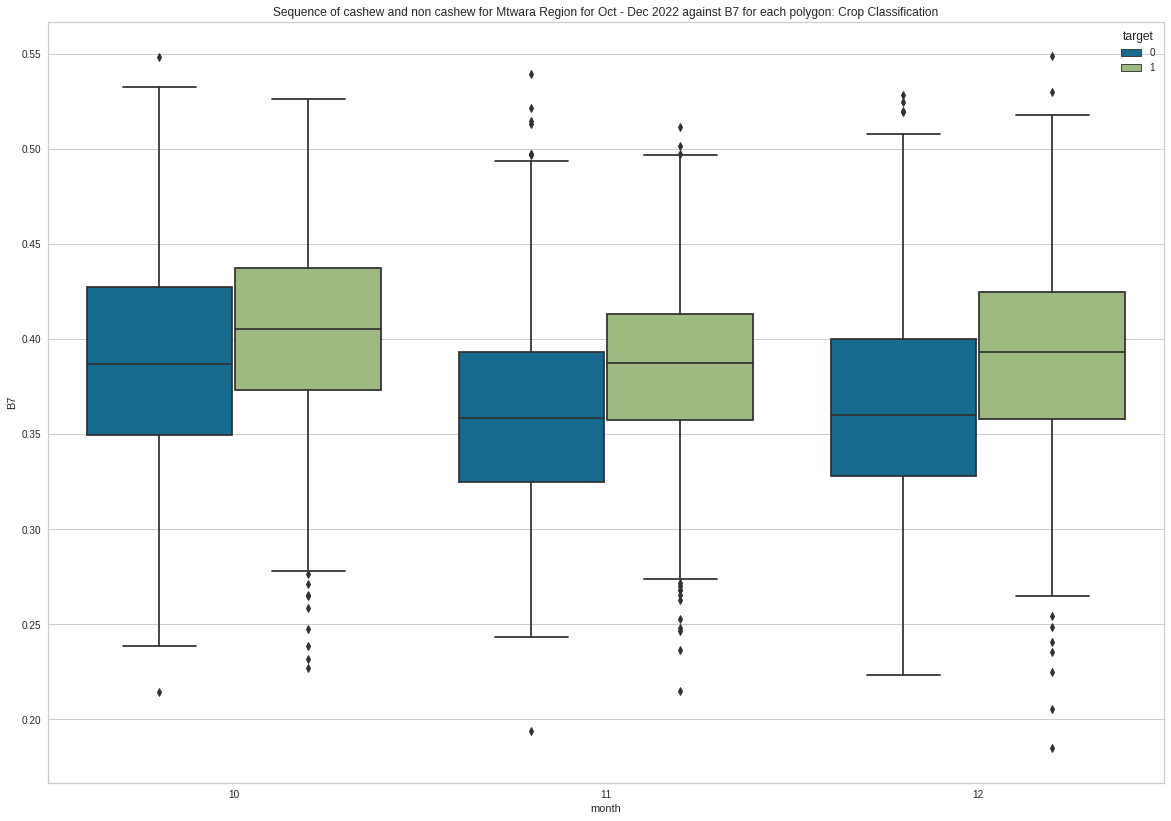

In [457]:
# NDVi vs B6 by polygon cluster
plt.figure(figsize=(20, 14))


sns.boxplot(data=trees_df, x="month", y="B7", hue="target").set(title='Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B7 for each polygon: Crop Classification')


[Text(0.5, 1.0, 'Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B8 for each polygon: Crop Classification')]

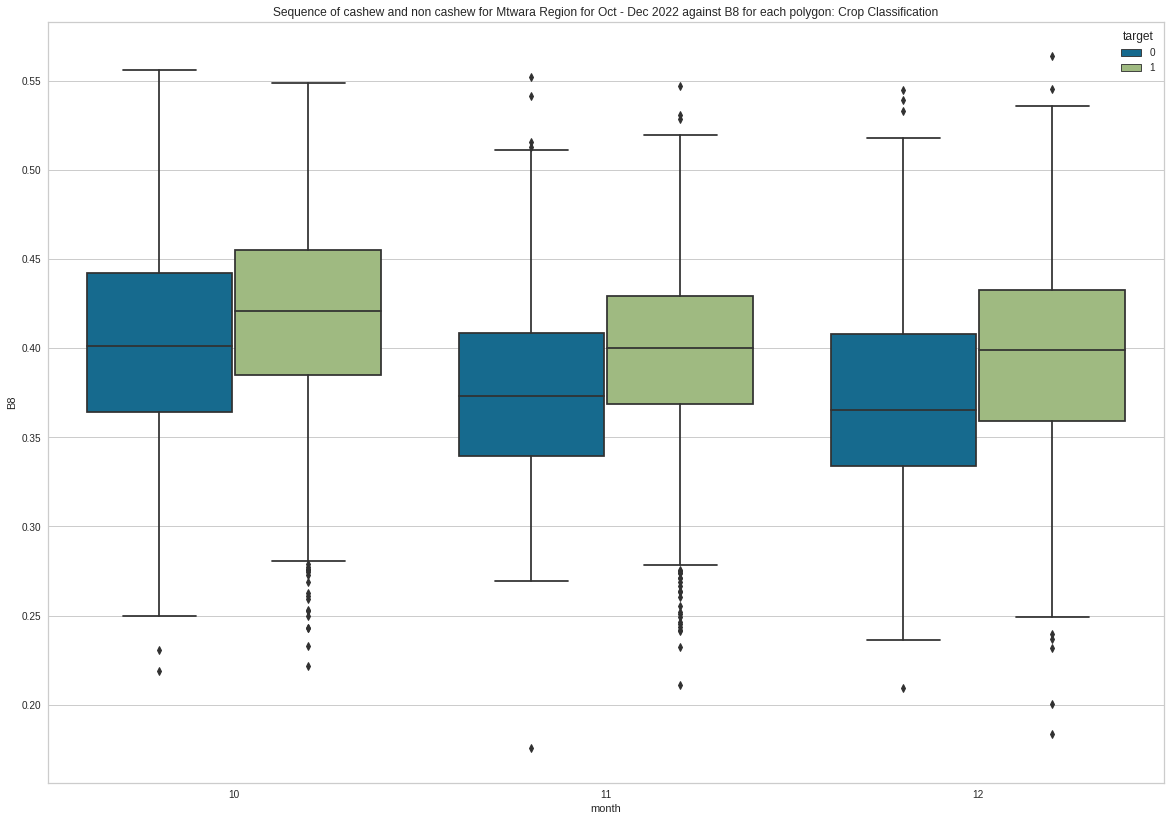

In [458]:
# NDVi vs B6 by polygon cluster
plt.figure(figsize=(20, 14))


sns.boxplot(data=trees_df, x="month", y="B8", hue="target").set(title='Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B8 for each polygon: Crop Classification')


[Text(0.5, 1.0, 'Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B8A for each polygon: Crop Classification')]

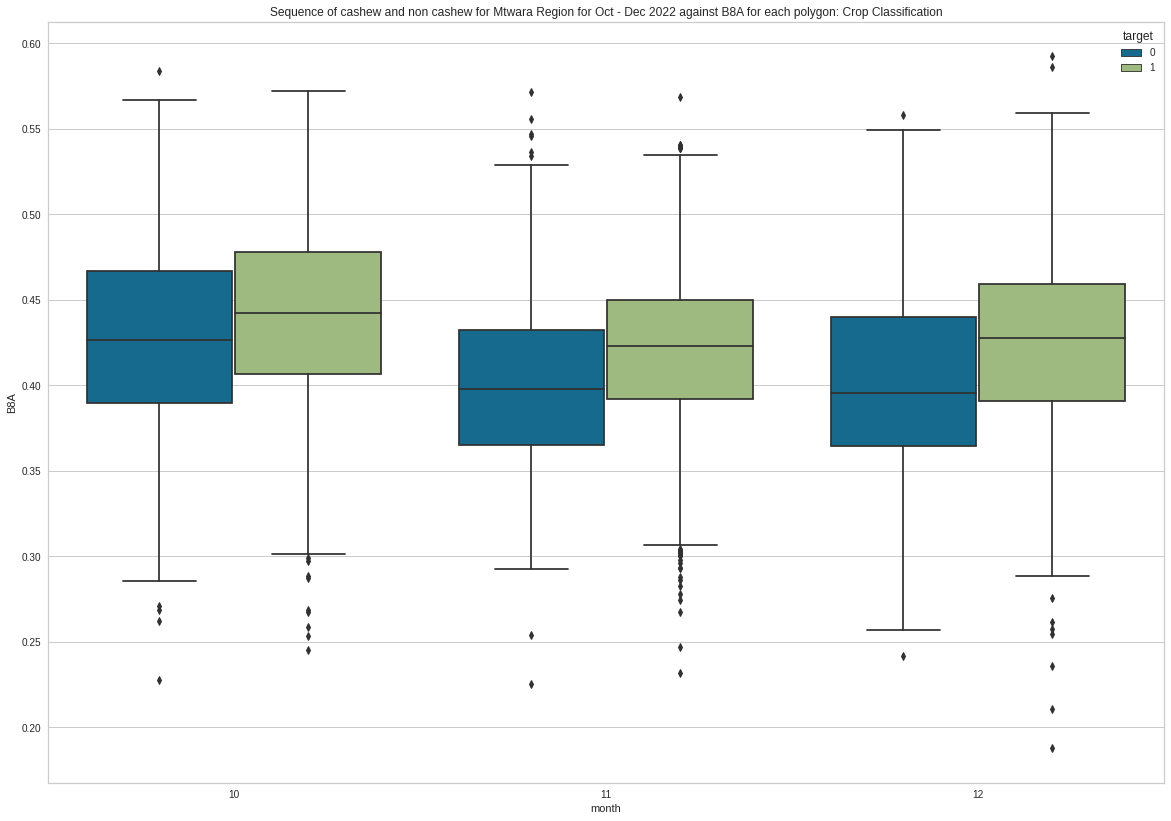

In [459]:
# NDVi vs B6 by polygon cluster
plt.figure(figsize=(20, 14))


sns.boxplot(data=trees_df, x="month", y="B8A", hue="target").set(title='Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B8A for each polygon: Crop Classification')


[Text(0.5, 1.0, 'Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B11 for each polygon: Crop Classification')]

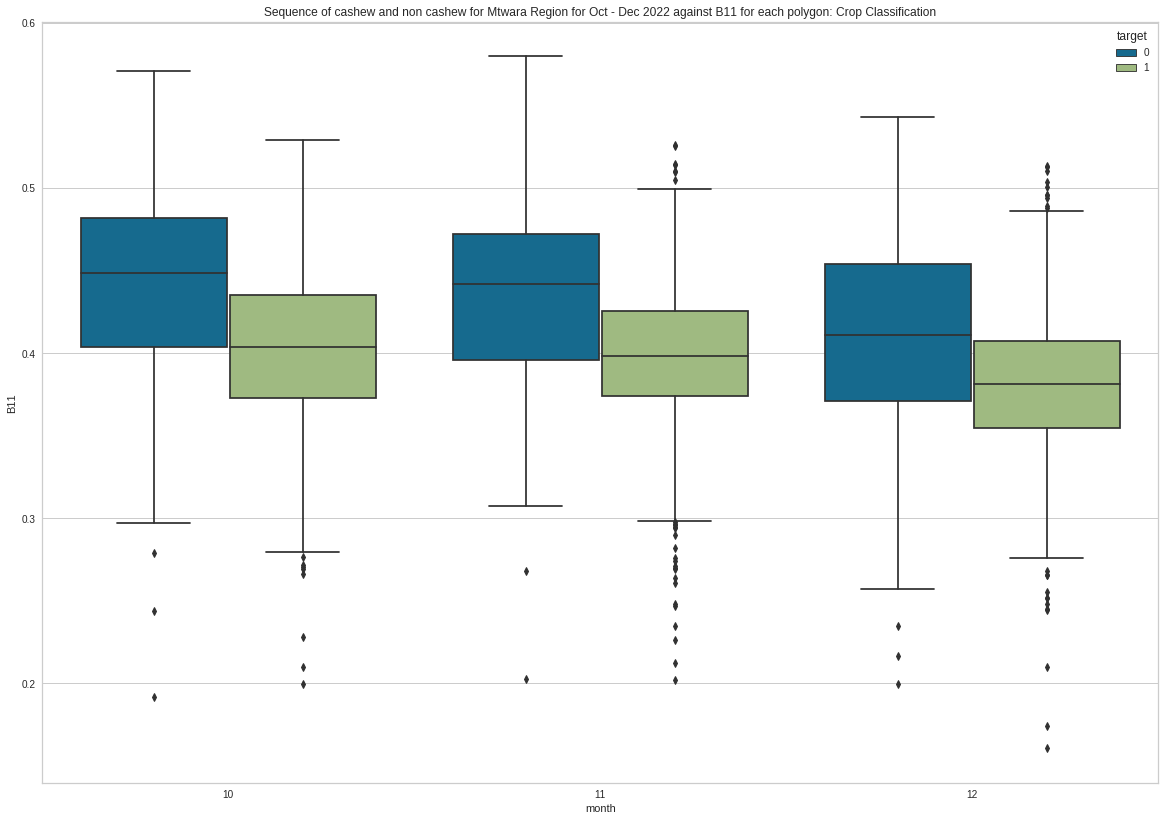

In [460]:
# NDVi vs B6 by polygon cluster
plt.figure(figsize=(20, 14))

sns.boxplot(data=trees_df, x="month", y="B11", hue="target").set(title='Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B11 for each polygon: Crop Classification')


[Text(0.5, 1.0, 'Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B12 for each polygon: Crop Classification')]

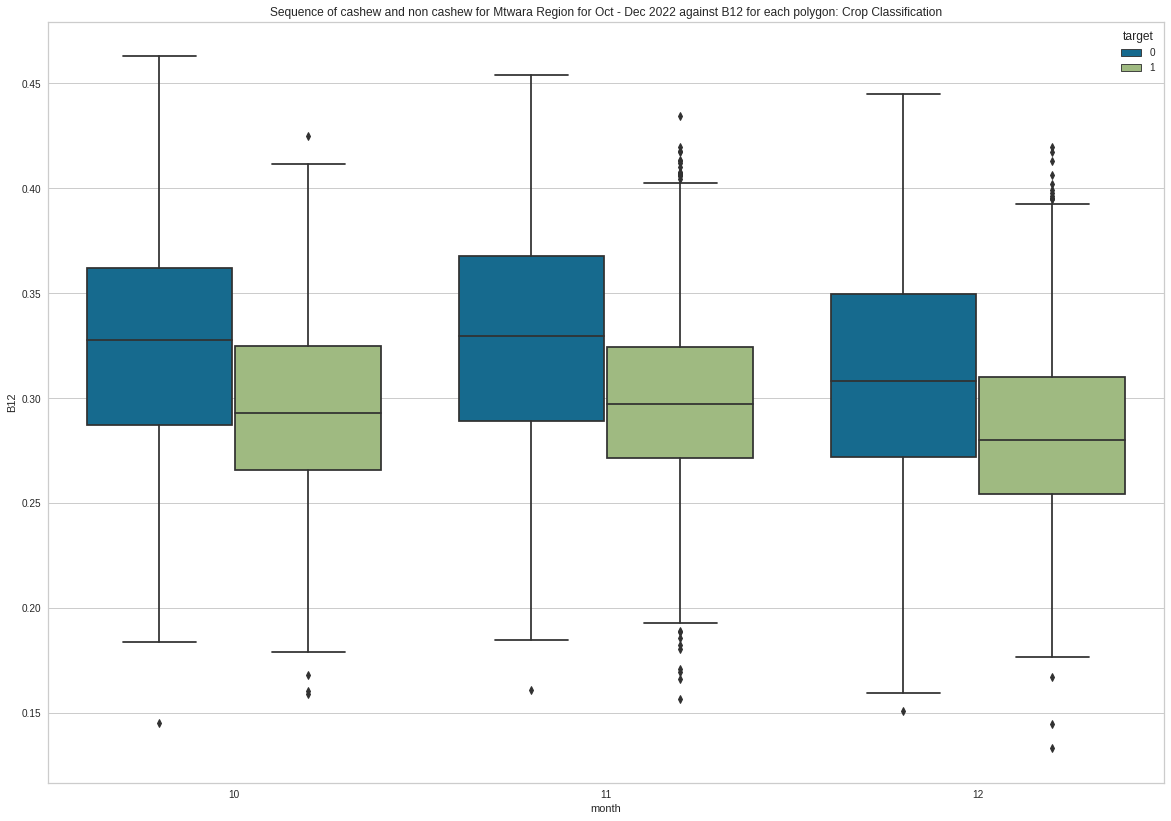

In [461]:
# NDVi vs B6 by polygon cluster
plt.figure(figsize=(20, 14))


sns.boxplot(data=trees_df, x="month", y="B12", hue="target").set(title='Sequence of cashew and non cashew for Mtwara Region for Oct - Dec 2022 against B12 for each polygon: Crop Classification')


# Model

In [462]:
trees_df.head(2)

,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,...,B12,SCL,CLD,target,ndvi,day of year,month,year,polygon_cluster,evi
21,2022-10-04 07:42:54,0.151225,0.146900,0.169525,0.179525,0.225600,0.300600,0.3240,0.33695,0.362350,...,0.294875,4.0,0.0,1,0.337393,277,10,2022,1,0.418149
33,2022-12-28 07:42:46,0.144075,0.151525,0.186000,0.180400,0.250475,0.358825,0.4024,0.41085,0.434275,...,0.313025,4.0,0.0,1,0.413023,362,12,2022,1,0.545416


Modeling Data By Single Month of November which has 5 days of 40 pixles.

In [463]:
trees_df = trees_df.drop(['B1', 'SCL', 'CLD',  'month', 'year', 'B9', 'datetime','month', 'year',	'polygon_cluster'	, 'evi'],axis=1)

In [464]:
from pycaret.classification import *

In [465]:
data_1=trees_df

In [466]:
data_1.head(2)

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,target,ndvi,day of year
21,0.146900,0.169525,0.179525,0.225600,0.300600,0.3240,0.33695,0.362350,0.382800,0.294875,1,0.337393,277
33,0.151525,0.186000,0.180400,0.250475,0.358825,0.4024,0.41085,0.434275,0.418575,0.313025,1,0.413023,362


In [467]:
data_1.shape

(5543, 13)

In [468]:
data_1.target.value_counts()

1    3796
0    1747
Name: target, dtype: int64

In [469]:
data_1.corr()

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,target,ndvi,day of year
B2,1.000000,0.920078,0.872170,0.787580,0.402586,0.382841,0.346795,0.408089,0.707759,0.637037,-0.320050,-0.455138,-0.207747
B3,0.920078,1.000000,0.851929,0.922633,0.640405,0.604490,0.578945,0.617288,0.732719,0.646364,-0.200466,-0.270689,-0.165366
B4,0.872170,0.851929,1.000000,0.829222,0.286158,0.246610,0.224313,0.272651,0.849191,0.838149,-0.418149,-0.665074,-0.175701
B5,0.787580,0.922633,0.829222,1.000000,0.687517,0.641807,0.612466,0.659296,0.826694,0.745658,-0.103577,-0.216449,-0.155325
B6,0.402586,0.640405,0.286158,0.687517,1.000000,0.990310,0.960326,0.981293,0.381565,0.210571,0.180761,0.506288,-0.125614
B7,0.382841,0.604490,0.246610,0.641807,0.990310,1.000000,0.965962,0.990217,0.352678,0.171511,0.173973,0.546682,-0.115999
B8,0.346795,0.578945,0.224313,0.612466,0.960326,0.965962,1.000000,0.965009,0.350364,0.157749,0.142460,0.546916,-0.173912
B8A,0.408089,0.617288,0.272651,0.659296,0.981293,0.990217,0.965009,1.000000,0.393357,0.184288,0.143630,0.530383,-0.145720
B11,0.707759,0.732719,0.849191,0.826694,0.381565,0.352678,0.350364,0.393357,1.000000,0.919819,-0.327878,-0.439509,-0.214284
B12,0.637037,0.646364,0.838149,0.745658,0.210571,0.171511,0.157749,0.184288,0.919819,1.000000,-0.278527,-0.588715,-0.111470


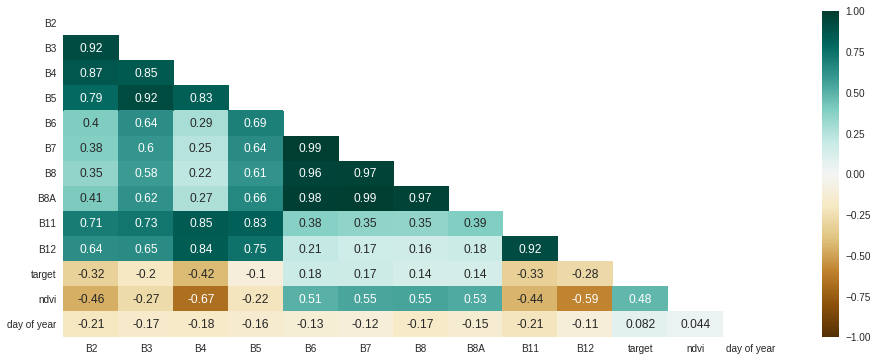

In [470]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(data_1.corr(), dtype=np.bool))
heatmap = sns.heatmap(data_1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [471]:
### Model

model_data = data_1.sample(frac=0.95, random_state=78)
data_unseen = pd.concat([model_data,data_1]).drop_duplicates(keep=False)
print('Data for Modeling: ' + str(model_data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (5266, 13)
Unseen Data For Predictions: (277, 13)


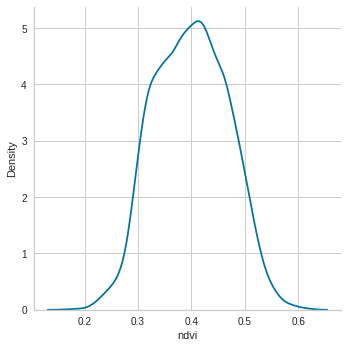

In [472]:
sns.displot(model_data, x="ndvi", kind="kde")

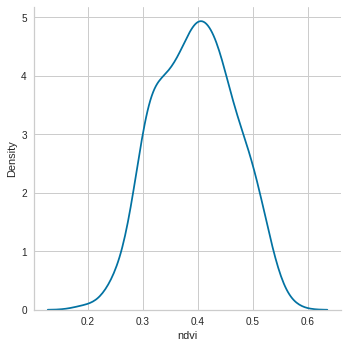

In [473]:
sns.displot(data_unseen, x="ndvi", kind="kde")

In [474]:
classifier = setup(data = model_data, target = 'target', remove_outliers = True)

,Description,Value
0,session_id,4939
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5266, 13)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='target',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('rem_outliers',
                 Outlier(contamination=0.05, methods=['pca'], random_state=4939,
                         target='target')),
                

In [475]:
# Model Comarison

In [476]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8858,0.9482,0.9253,0.9119,0.9185,0.7277,0.7282,0.230
rf,Random Forest Classifier,0.8712,0.9260,0.9261,0.8931,0.9091,0.6882,0.6903,0.646
gbc,Gradient Boosting Classifier,0.8695,0.9274,0.9302,0.8877,0.9084,0.6819,0.6843,0.992
lda,Linear Discriminant Analysis,0.8649,0.9229,0.9138,0.8946,0.9040,0.6761,0.6772,0.030
et,Extra Trees Classifier,0.8649,0.9239,0.9208,0.8893,0.9046,0.6734,0.6754,0.426
ada,Ada Boost Classifier,0.8443,0.9043,0.9117,0.8707,0.8907,0.6209,0.6232,0.301
dt,Decision Tree Classifier,0.8275,0.7971,0.8747,0.8771,0.8757,0.5934,0.5940,0.048
ridge,Ridge Classifier,0.8163,0.0000,0.9290,0.8284,0.8757,0.5287,0.5421,0.018
svm,SVM - Linear Kernel,0.8143,0.0000,0.8911,0.8534,0.8689,0.5462,0.5581,0.027
knn,K Neighbors Classifier,0.8058,0.8495,0.8595,0.8612,0.8602,0.5418,0.5422,0.121


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4939, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


In [484]:
Light_Gradient_Boosting_Machine = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8746,0.9288,0.9303,0.8937,0.9116,0.6963,0.6979
1,0.8429,0.9314,0.8930,0.8821,0.8875,0.6269,0.6270
2,0.8743,0.9407,0.9177,0.9028,0.9102,0.7007,0.7010
3,0.8914,0.9376,0.9259,0.9184,0.9221,0.7429,0.7430
4,0.9057,0.9552,0.9424,0.9234,0.9328,0.7750,0.7754
5,0.8971,0.9493,0.9383,0.9157,0.9268,0.7538,0.7545
6,0.9029,0.9665,0.9221,0.9375,0.9298,0.7724,0.7727
7,0.8714,0.9490,0.9016,0.9129,0.9072,0.6979,0.6981
8,0.9057,0.9678,0.9467,0.9203,0.9333,0.7725,0.7734


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 7
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4939, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [485]:
evaluate_model(Light_Gradient_Boosting_Machine)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4939, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [486]:
tuned_model = tune_model(Light_Gradient_Boosting_Machine )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8718,0.9164,0.9303,0.8902,0.9098,0.6885,0.6905
1,0.8714,0.9278,0.9095,0.9057,0.9076,0.6963,0.6963
2,0.8629,0.9326,0.9095,0.8947,0.9020,0.6735,0.6738
3,0.8886,0.9376,0.9300,0.9113,0.9206,0.7340,0.7345
4,0.8914,0.9500,0.9383,0.9084,0.9231,0.7388,0.7399
5,0.8971,0.9507,0.9424,0.9124,0.9271,0.7525,0.7537
6,0.8971,0.9644,0.9221,0.9298,0.9259,0.7577,0.7578
7,0.8829,0.9373,0.9221,0.9109,0.9165,0.7203,0.7205
8,0.9143,0.9644,0.9549,0.9246,0.9395,0.7926,0.7938


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 8
INFO:logs:LGBMClassifier(bagging_fraction=0.4, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=140, n_jobs=-1, num_leaves=90, objective=None,
               random_state=4939, reg_alpha=0.1, reg_lambda=1e-07,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


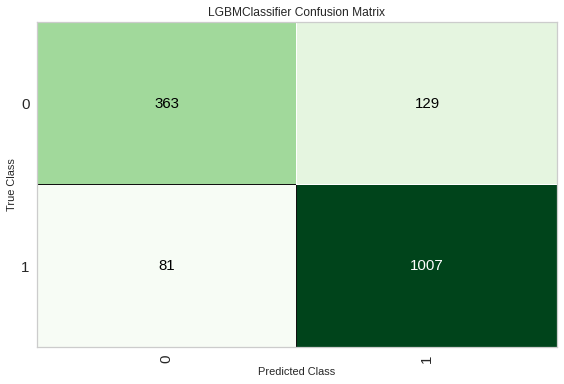

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [487]:
plot_model(tuned_model, plot='confusion_matrix')

In [488]:
predict_model(tuned_model)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.4, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=140, n_jobs=-1, num_leaves=90, objective=None,
               random_state=4939, reg_alpha=0.1, reg_lambda=1e-07,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8671,0.9357,0.9256,0.8864,0.9056,0.6816,0.6834


,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,...,day of year_327,day of year_332,day of year_337,day of year_342,day of year_347,day of year_352,day of year_362,target,Label,Score
0,0.178425,0.204725,0.188375,0.258750,0.394050,0.436750,0.46210,0.480275,0.387475,0.257225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9300
1,0.146475,0.156450,0.153450,0.199500,0.258125,0.281975,0.27005,0.311650,0.287600,0.216675,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9718
2,0.151000,0.188075,0.174375,0.256875,0.374775,0.420250,0.42790,0.446075,0.380525,0.305575,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.9970
3,0.144975,0.186450,0.166850,0.247975,0.357350,0.395700,0.41345,0.416350,0.341375,0.270850,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.9968
4,0.188275,0.213150,0.220675,0.286300,0.368550,0.408650,0.41535,0.452925,0.492625,0.356175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.7288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,0.148875,0.170475,0.161200,0.224150,0.313900,0.355900,0.36920,0.390450,0.390675,0.300225,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.8209
1576,0.137975,0.163250,0.150975,0.220800,0.326025,0.355700,0.37530,0.392375,0.374825,0.256375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9728
1577,0.165550,0.196950,0.221550,0.300275,0.358050,0.398675,0.37025,0.428900,0.499250,0.417400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8690
1578,0.145800,0.169450,0.162650,0.227800,0.326175,0.381975,0.34920,0.409500,0.375250,0.303950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9885


In [489]:
final_model = finalize_model(tuned_model)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LGBMClassifier(bagging_fraction=0.4, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=140, n_jobs=-1, num_leaves=90, objective=None,
               random_state=4939, reg_alpha=0.1, reg_lambda=1e-07,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing LGBMClassifier(bagging_fraction=0.4, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
       

In [490]:
predict_model(final_model);

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.4, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=140, n_jobs=-1, num_leaves=90, objective=None,
               random_state=4939, reg_alpha=0.1, reg_lambda=1e-07,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.988,0.9993,0.9917,0.9908,0.9913,0.9719,0.9719


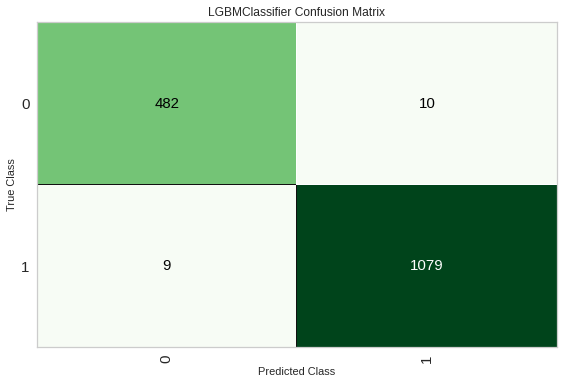

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [491]:
plot_model(final_model, plot='confusion_matrix')

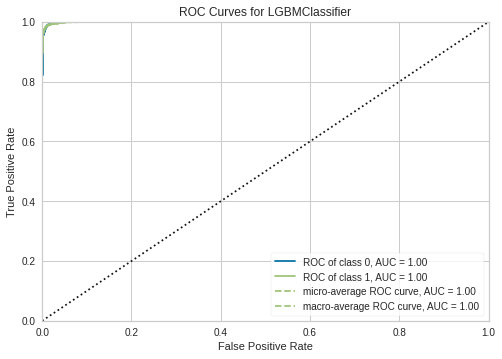

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [492]:
plot_model(final_model)

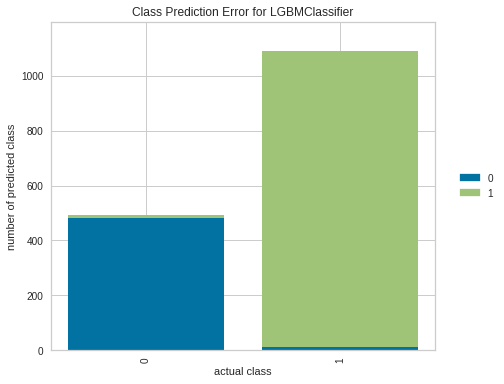

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [493]:
plot_model(final_model, plot = 'error')

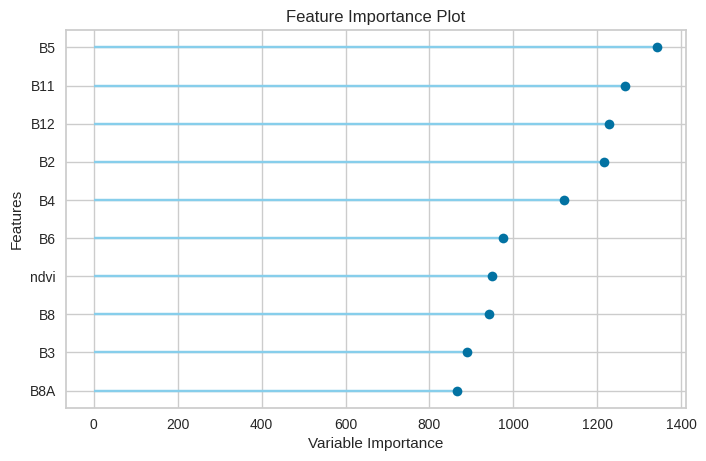

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [494]:
  plot_model(final_model, plot='feature')

In [496]:
data_unseen

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,target,ndvi,day of year
177,0.164750,0.187725,0.187850,0.259025,0.345675,0.381075,0.37940,0.408800,0.401750,0.317350,1,0.370318,342
360,0.157050,0.184300,0.181450,0.248650,0.332975,0.370500,0.37275,0.402925,0.413575,0.317950,1,0.378995,322
434,0.144075,0.166625,0.179175,0.243925,0.297725,0.320625,0.32460,0.347600,0.402325,0.315450,1,0.319729,317
523,0.155725,0.184150,0.177375,0.266300,0.371175,0.410450,0.40715,0.449950,0.408575,0.309200,1,0.434504,292
542,0.169625,0.204300,0.226450,0.285325,0.376250,0.410300,0.41995,0.448450,0.464600,0.371325,1,0.328938,277
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21400,0.199475,0.227050,0.247900,0.293750,0.364475,0.400475,0.43150,0.447800,0.517175,0.392450,0,0.287336,292
21413,0.230200,0.248400,0.257600,0.312200,0.408250,0.460375,0.47160,0.495825,0.534500,0.396100,0,0.316189,282
21420,0.156300,0.179800,0.207950,0.250200,0.294275,0.323625,0.33665,0.358500,0.445300,0.373000,0,0.265778,332
21421,0.171350,0.195300,0.229950,0.264525,0.287950,0.313675,0.31650,0.341825,0.481600,0.428275,0,0.195663,362


In [497]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.4, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=140, n_jobs=-1, num_leaves=90, objective=None,
               random_state=4939, reg_alpha=0.1, reg_lambda=1e-07,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8953,0.9471,0.9333,0.9081,0.9205,0.7672,0.7678


,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,target,ndvi,day of year,Label,Score
177,0.164750,0.187725,0.187850,0.259025,0.345675,0.381075,0.37940,0.408800,0.401750,0.317350,1,0.370318,342,1,0.9841
360,0.157050,0.184300,0.181450,0.248650,0.332975,0.370500,0.37275,0.402925,0.413575,0.317950,1,0.378995,322,1,0.9460
434,0.144075,0.166625,0.179175,0.243925,0.297725,0.320625,0.32460,0.347600,0.402325,0.315450,1,0.319729,317,1,0.8628
523,0.155725,0.184150,0.177375,0.266300,0.371175,0.410450,0.40715,0.449950,0.408575,0.309200,1,0.434504,292,1,0.9954
542,0.169625,0.204300,0.226450,0.285325,0.376250,0.410300,0.41995,0.448450,0.464600,0.371325,1,0.328938,277,0,0.7760


In [498]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['target'], unseen_predictions['Label'], metric = 'Recall')


0.9333

In [499]:
check_metric(unseen_predictions['target'], unseen_predictions['Label'], metric = 'Accuracy')


0.8953

In [500]:
check_metric(unseen_predictions['target'], unseen_predictions['Label'], metric = 'Precision')


0.9081

In [501]:
check_metric(unseen_predictions['target'], unseen_predictions['Label'], metric = 'F1')

0.9205

# Useful Content